# Stage 4a: Demonstrate using AI Alpha and Daily Betas to produce optiomal weights

In [14]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import utils
importlib.reload(utils)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)

print(f'Python version : {python_version()}')
print(f'Pandas version : {pd.__version__}')

Python version : 3.8.10
Pandas version : 0.25.3


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [58]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

# For Chromedriver
from pathlib import Path
chrome_executabel_path = str(Path.home()) + r'\Anaconda Projects\chromedriver\chromedriver'

# Make sure we have a data directory
Path('./data').mkdir(parents=True, exist_ok=True) 

masked_account_number = '#---5311'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories.csv'

In [59]:
td_ameritrade = amc.AmeritradeRest(username, password, client_id, chrome_executabel_path)
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    print('Error: No authorization data: {}'.format(td_ameritrade.authorization))
else:
    print('You have authorization')

You have authorization


# Gather Data

- Current Holdings
- Price Histories
- AI Alpha
- Daily Beta

## First lets see why stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

In [60]:
# Specific Portfolio Account
account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')

# Filter out non Equity investments
current_stocks = amc.AmeritradeRest(username, password, client_id).get_quotes(utils.get_investment_symbols(equity_investments_df)).query('assetType == "EQUITY"').index.tolist()
current_investments_df = equity_investments_df[equity_investments_df['symbol'].isin(current_stocks)]
current_investments_df

,account,shortQuantity,averagePrice,currentDayProfitLoss,currentDayProfitLossPercentage,longQuantity,settledLongQuantity,settledShortQuantity,marketValue,maintenanceRequirement,currentDayCost,previousSessionLongQuantity,assetType,cusip,symbol,description,type
4,#---5311,0.0,21.62526,2.000000e-12,0.0,783.0,783.0,0.0,12661.11,12661.11,0.0,783.0,EQUITY,88688T100,TLRY,0,0
11,#---5311,0.0,0.14474,0.000000e+00,0.0,45000.0,45000.0,0.0,8673.75,0.00,0.0,45000.0,EQUITY,Q3860H107,FGPHF,0,0
12,#---5311,0.0,13.74495,0.000000e+00,0.0,2000.0,2000.0,0.0,25960.00,25960.00,0.0,2000.0,EQUITY,98138J206,WKHS,0,0
13,#---5311,0.0,0.04960,0.000000e+00,0.0,250.0,250.0,0.0,6.75,0.00,0.0,250.0,EQUITY,Q3394D101,EEENF,0,0
14,#---5311,0.0,59.22000,0.000000e+00,0.0,50.0,50.0,0.0,2454.50,2454.50,0.0,50.0,EQUITY,26142R104,DKNG,0,0


In [122]:
holdings = utils.read_port_data(portfolio_file_name).set_index('symbol')
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
pricing = utils.get_close_values(price_histories)
print(f'You have {len(pricing.columns)} stocks from picing')

alpha_vectors = pd.read_csv('data/alpha_vectors.csv', parse_dates=['date']).set_index(['date']).sort_index()
print(f'You have {len(alpha_vectors.columns)} stocks from alpha')

with open('data/daily_beta.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    daily_betas = pickle.load(f)
print(f'You have {len(daily_betas)} of daily betas')

Date range for price histories: 2018-07-09 to 2021-07-09
You have 526 stocks from picing
You have 526 stocks from alpha
You have 253 of daily betas


In [42]:
alpha_vectors[list(daily_betas.keys())[0]:]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL,ZKIN
date,,,,,,,,,,,,,,,,,,,,,
2020-07-09 00:00:00+00:00,-0.017318,0.006440,0.007521,-0.003986,-0.030537,-0.042700,0.024894,-0.027049,-0.026772,-0.016136,...,-0.007764,0.014912,0.027108,0.004196,-0.028653,0.004563,-0.003414,0.007280,-0.013381,0.020735
2020-07-10 00:00:00+00:00,-0.018511,0.006526,0.005535,-0.005307,-0.030796,-0.042700,0.025696,-0.028785,-0.030206,-0.016136,...,-0.010518,0.014719,0.024030,0.004912,-0.036954,0.004484,-0.003681,0.006608,-0.013897,0.020417
2020-07-13 00:00:00+00:00,-0.023022,0.006643,0.003887,-0.005255,-0.031838,-0.042701,0.025518,-0.032192,-0.037709,-0.013929,...,-0.010184,0.011028,0.022619,0.004906,-0.041676,0.004572,-0.003685,0.006274,-0.007748,0.022593
2020-07-14 00:00:00+00:00,-0.032265,0.007609,0.004170,-0.004490,-0.032387,-0.042699,0.026129,-0.038843,-0.042403,-0.027518,...,-0.011721,0.010401,0.022639,0.006505,-0.042606,0.004825,-0.004043,0.007141,-0.002762,0.013813
2020-07-15 00:00:00+00:00,-0.034709,0.007551,0.004684,-0.005263,-0.032778,-0.042824,0.027629,-0.040205,-0.043427,-0.028755,...,-0.016423,0.009160,0.022594,0.006526,-0.042601,0.004725,-0.006307,0.006633,0.002581,0.008417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 00:00:00+00:00,-0.036985,0.000282,0.005408,-0.013583,-0.040213,-0.034261,-0.000610,-0.016623,0.007886,-0.003111,...,-0.016633,-0.012584,-0.003373,0.026059,-0.032931,0.019831,0.024167,-0.024999,0.001402,0.008564
2021-07-06 00:00:00+00:00,-0.036923,0.002747,0.005662,-0.014493,-0.039214,-0.035564,-0.008545,-0.016623,0.008414,-0.008854,...,-0.015931,-0.015927,-0.003986,0.024971,-0.032861,0.019831,0.024032,-0.025372,0.001402,0.008654
2021-07-07 00:00:00+00:00,-0.036816,0.003117,0.006021,-0.012944,-0.036715,-0.037431,-0.014260,-0.016838,0.005099,-0.011259,...,-0.013362,-0.018118,-0.006042,0.020583,-0.032456,0.019835,0.024829,-0.022993,0.001402,0.008669


In [47]:
daily_betas.keys()

dict_keys(['07/09/2020', '07/10/2020', '07/13/2020', '07/14/2020', '07/15/2020', '07/16/2020', '07/17/2020', '07/20/2020', '07/21/2020', '07/22/2020', '07/23/2020', '07/24/2020', '07/27/2020', '07/28/2020', '07/29/2020', '07/30/2020', '07/31/2020', '08/03/2020', '08/04/2020', '08/05/2020', '08/06/2020', '08/07/2020', '08/10/2020', '08/11/2020', '08/12/2020', '08/13/2020', '08/14/2020', '08/17/2020', '08/18/2020', '08/19/2020', '08/20/2020', '08/21/2020', '08/24/2020', '08/25/2020', '08/26/2020', '08/27/2020', '08/28/2020', '08/31/2020', '09/01/2020', '09/02/2020', '09/03/2020', '09/04/2020', '09/08/2020', '09/09/2020', '09/10/2020', '09/11/2020', '09/14/2020', '09/15/2020', '09/16/2020', '09/17/2020', '09/18/2020', '09/21/2020', '09/22/2020', '09/23/2020', '09/24/2020', '09/25/2020', '09/28/2020', '09/29/2020', '09/30/2020', '10/01/2020', '10/02/2020', '10/05/2020', '10/06/2020', '10/07/2020', '10/08/2020', '10/09/2020', '10/12/2020', '10/13/2020', '10/14/2020', '10/15/2020', '10/16/20

## Generate Daily Optimal Portfolios using 1 year of alpha and beta
Start with the last date, subtract 1 year to get the start and end dates for the betas.

In [103]:
start_date = list(daily_betas.keys())[0]
end_date = list(daily_betas.keys())[-1]
print(f'Generating 1 year Optimal Portfolios from {start_date} to {end_date}')
for opt_date, risk_model in daily_betas.items():
    alpha_vector = pd.DataFrame(alpha_vectors.loc[opt_date])
    risk_model = daily_betas[opt_date]

Generating 1 year Optimal Portfolios from 07/09/2020 to 07/09/2021


In [52]:
import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
importlib.reload(portfolio_optimizer)

<module 'portfolio_optimizer' from 'C:\\Users\\HP-Z440\\Anaconda Projects\\svi-trading-tools\\analysis-20210703\\../tools\\portfolio_optimizer.py'>

In [123]:
holding_weights = utils.get_portfolio_weights(holdings).squeeze()

In [126]:
optimal_weights = OptimalHoldings(risk_cap=0.05,weights_max=0.10, weights_min=0.0).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

Old portfolio variance is:  0.06247432
New portfolio variance is:  0.01705764


,optimalWeights
A,-0.0
AAL,0.0
AAP,0.0
AAPL,-0.0
ABBV,-0.0
...,...
XLNX,0.0
XOM,10.0
XRAY,-0.0
XYL,0.0


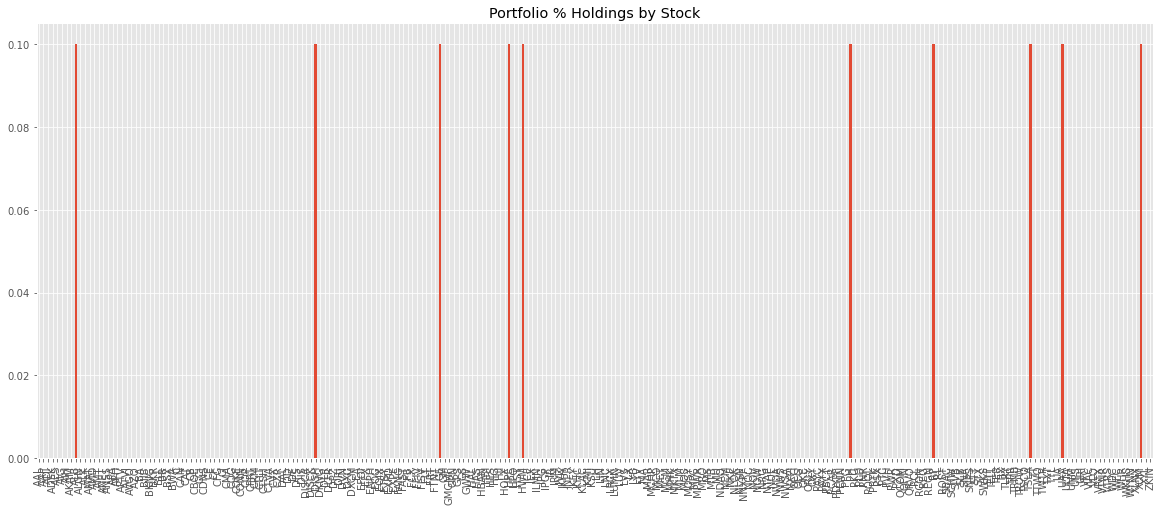

In [129]:
print(f'Old portfolio variance is:  {risk_model.compute_portfolio_variance(holding_weights.values):.8f}')
print(f'New portfolio variance is:  {risk_model.compute_portfolio_variance(optimal_weights):.8f}')
display((optimal_weights*100).round(2))
optimal_weights.query('optimalWeights > 0').plot.bar(legend=None, title='Portfolio % Holdings by Stock')

#x_axis = plt.axes().get_xaxis()
#x_axis.set_visible(False)

In [132]:
optimal_weights.query('optimalWeights > 0.0').shape

(242, 1)

In [ ]:
investment_amount = portfun.get_account_value(stock_universe_values).round(2)
print(f'Current investment amount: {investment_amount}')
optimal_weights['amount'] = (optimal_weights['optimalWeights'] * investment_amount).round(0)
optimal_weights['marketValue'] = stock_universe_values['marketValue']
optimal_weights['buy/sell'] = (optimal_weights['marketValue'] - optimal_weights['amount']) * -1
optimal_weights['close'] = pricing.iloc[-1]
optimal_weights['existingShares'] = stock_universe_values['longQuantity']
optimal_weights['deltaShares'] = (optimal_weights['buy/sell'] / optimal_weights['close']).round(0)
optimal_weights['deltaMarketValue'] = (optimal_weights['deltaShares'] * optimal_weights['close'])
optimal_weights['totalShares'] = (optimal_weights['existingShares'] + optimal_weights['deltaShares'])
optimal_weights['totalMarketValue'] = (optimal_weights['totalShares'] * optimal_weights['close'])
optimal_weights

## Think or Swim Simulator

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] <= 0) & (optimal_weights['deltaShares'] == 0)].round(2)

In [ ]:
optimal_weights[(optimal_weights['totalShares'] > 0) | (optimal_weights['deltaShares'] != 0)][['deltaMarketValue', 'totalMarketValue']].sum().round(2)